In [6]:
!pip freeze | grep cellpose

cellpose==2.1.1


In [57]:
import torch
print(torch.cuda.is_available())
from cellpose.models import CellposeModel, Cellpose
from os import path
import cellpose
import GPUtil
from aicsimageio import AICSImage
import logging
import numpy as np
from tqdm import tqdm
import yaml
from matplotlib import pyplot as plt
import zarr
from dask import array as da
log_file=path.join("/tmp/cellpose_{jj}.log")
# cellpose.logger.handlers=[]
# cellpose.logger.addHandler(logging.FileHandler(log_file))
# cellpose.logger.addHandler(logging.StreamHandler(sys.stdout))

True


In [3]:
import sys
sys.path.append("/mnt/showers/AxioObserver7/ImageData/Fukai/image_analysis/230203_timelapse")
from utils import percentile_normalize

In [4]:
basedir = "/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/"
workdir = "/work/fukai/2023-01-27-timelapse/"
file_path_frames = [
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-02-03/230203-atRA-nolive-stage-staining.czi",0),
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-02-03/230203-atRA-live-staining.czi",0),
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-02-03/230203-atRA-nolive-staining.czi",0),
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-02-03/230203-control-nolive-staining.czi",0),
    ("/mnt/showers/AxioObserver7/ImageData/Fukai/2023-01-27-timelapse/2023-01-30/230130-atRA-live-2.czi/230130-atRA-live-2_AcquisitionBlock1.czi/230130-atRA-live-2_AcquisitionBlock1_pt1.czi",100)
]

In [5]:
cellpose_model_path="/mnt/showers/AxioObserver7/ImageData/Fukai/cellpose/models/cellpose_residual_on_style_on_concatenation_off_cellpose_2021_04_02_08_32_54.191693"
cellprob_threshold=0.1
flow_threshold=0.4
cellpose_normalize=True
diameter=0

In [6]:
file_path = file_path_frames[0][0]    
frame = file_path_frames[0][1]
zarr_path = path.join(workdir,path.relpath(file_path,basedir)+"_rescaled.zarr")
image = da.from_zarr(zarr_path,component="image")
metadata_path = path.join(workdir,path.relpath(file_path,basedir)+"_metadata.yaml")
with open(metadata_path,"r") as f:
    channel_names = yaml.safe_load(f)["channel_names"]

In [7]:
image.shape

(4, 88, 1, 2048, 2048)

In [8]:
all_deviceIDs=GPUtil.getAvailable("id",limit=10,maxMemory=1.0,maxLoad=1.0)
excludeID = []
print(all_deviceIDs)
while True:
    deviceIDs=GPUtil.getAvailable(
        "memory",maxMemory=1.0,
        excludeID=excludeID)
    if len(deviceIDs)>0:
        gpu_index=deviceIDs[0]
        break
print(gpu_index)

[0, 1, 2, 3]
1


In [34]:
shape_mask=image.shape[1:]
chunks=[1,*shape_mask[1:]]
zarr_file=zarr.open(zarr_path,"r+")
ds_mask=zarr_file.create_dataset(f"mask",
            shape=shape_mask,
            chunks=chunks,
            dtype=np.int32,
            overwrite=True)
ds_flow=zarr_file.create_dataset(f"flow_hsv",
            shape=[*shape_mask,3],
            chunks=[*chunks,3],
            dtype=np.int32,
            overwrite=True)
ds_prob=zarr_file.create_dataset(f"cell_prob",
            shape=shape_mask,
            chunks=chunks,
            dtype=np.float32,
            overwrite=True) 

In [35]:
cyto_channel = "Phase10x"
c_channel_ind = channel_names.index(cyto_channel)
nucleus_channels = []
cyto_img=image[c_channel_ind]
if len(nucleus_channels) > 0:
    nucleus_img=np.mean([
        percentile_normalize(image[channel_names.index(nucleus_channel)])
        for nucleus_channel in nucleus_channels],axis=0)
    prediction_img=np.array([cyto_img,nucleus_img])
    prediction_channels=[1,2]
else:
    prediction_img=np.array(cyto_img)
    prediction_channels=[0,0]

In [36]:
def cellpose_prediction(prediction_img,prediction_channels):
    if cellpose_model_path is None:
        model = Cellpose(gpu=True,torch=True,
                            device=torch.device(gpu_index))
        masks, flow, _, _ = model.eval(\
            [prediction_img], channels=prediction_channels)
    else:
        model = CellposeModel(
            gpu=True,
            device=torch.device(gpu_index),
            pretrained_model=cellpose_model_path, 
        )
        masks, flow, _ = model.eval(
            [prediction_img],rescale=[1.], 
            channels=prediction_channels,
            cellprob_threshold=cellprob_threshold,
            diameter=diameter,
            normalize=cellpose_normalize,
            flow_threshold=flow_threshold)
    return masks[0], flow[0]

In [23]:
m=10
z=0
mask, flow = cellpose_prediction(prediction_img[m,z],prediction_channels)

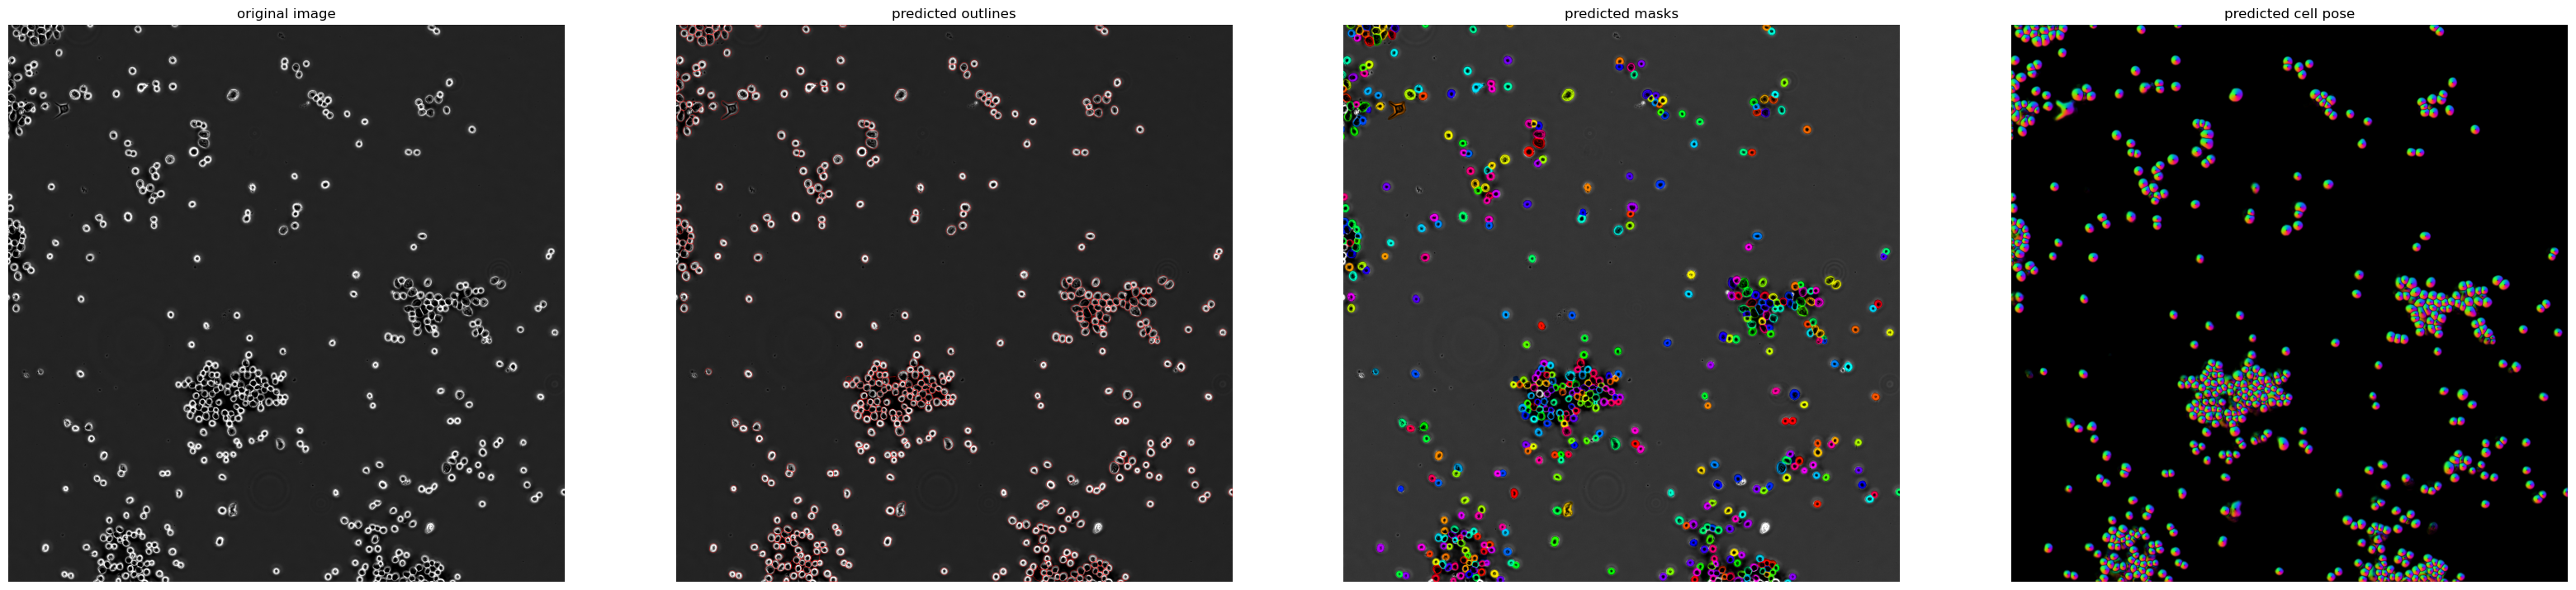

In [24]:
fig = plt.figure(figsize=(40,10))
cellpose.plot.show_segmentation(
    fig, 
    prediction_img[m,z], 
    mask, 
    flow[0],
    channels=prediction_channels)

In [58]:
for m in tqdm(range(image.shape[1])):
    mask, flow = cellpose_prediction(prediction_img[m,0],prediction_channels)
    ds_mask[m,0,:,:] = mask
    ds_flow[m,0,:,:] = flow[0]
    ds_prob[m,0,:,:] = flow[2]

100%|██████████| 88/88 [05:36<00:00,  3.82s/it]


In [ ]:
for m in tqdm(range(image.shape[1])):
    plt.imshow(ds_mask[m,0,:,:])
    plt.show()

# Run for all images

In [60]:
for j, (file_path, frame) in enumerate(file_path_frames):
    print(j)
    zarr_path = path.join(workdir,path.relpath(file_path,basedir)+"_rescaled.zarr")
    image = da.from_zarr(zarr_path,component="image")
    metadata_path = path.join(workdir,path.relpath(file_path,basedir)+"_metadata.yaml")
    with open(metadata_path,"r") as f:
        channel_names = yaml.safe_load(f)["channel_names"]

    shape_mask=image.shape[1:]
    chunks=[1,*shape_mask[1:]]
    zarr_file=zarr.open(zarr_path,"r+")
    ds_mask=zarr_file.create_dataset(f"mask",
                shape=shape_mask,
                chunks=chunks,
                dtype=np.int32,
                overwrite=True)
    ds_flow=zarr_file.create_dataset(f"flow_hsv",
                shape=[*shape_mask,3],
                chunks=[*chunks,3],
                dtype=np.int32,
                overwrite=True)
    ds_prob=zarr_file.create_dataset(f"cell_prob",
                shape=shape_mask,
                chunks=chunks,
                dtype=np.float32,
                overwrite=True) 

    c_channel_ind = channel_names.index(cyto_channel)
    nucleus_channels = []
    cyto_img=image[c_channel_ind]
    if len(nucleus_channels) > 0:
        nucleus_img=np.mean([
            percentile_normalize(image[channel_names.index(nucleus_channel)])
            for nucleus_channel in nucleus_channels],axis=0)
        prediction_img=np.array([cyto_img,nucleus_img])
        prediction_channels=[1,2]
    else:
        prediction_img=np.array(cyto_img)
        prediction_channels=[0,0]
    for m in tqdm(range(image.shape[1])):
        mask, flow = cellpose_prediction(prediction_img[m,0],prediction_channels)
        ds_mask[m,0,:,:] = mask
        ds_flow[m,0,:,:] = flow[0]
        ds_prob[m,0,:,:] = flow[2]

0


  0%|          | 0/88 [00:00<?, ?it/s]